# AGN and SFR in merger simulations
In this notebook, we use data from [Dietricht et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018MNRAS.480.3562D/abstract) to replor the results from their figure 10. First, we import the Python packages

In [1]:
import warnings

import matplotlib
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.table import Table
from astropy.cosmology import Planck13
from astropy import constants as const

import numpy as np

from scipy.io import readsav
from scipy.signal import argrelextrema

warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)

## Standard Plot Format
Setup the standard plotting format and make the plot.

In [2]:
# graphic aspect ratio = width/height
ASPECT = 16.0/12.0

# Text width in inches - don't change, this is defined by the print layout
TEXTWIDTH = 5.14  # inches

# output format and resolution
FIG_FMT = 'pdf'
DPI = 300

# Graphic dimensions
PLT_W = DPI*TEXTWIDTH
PLT_H = PLT_W/ASPECT
AX_FONTSIZE = 10
LAB_FONTSIZE = 8
LWIDTH = 0.5
AX_PAD = 3
WINCHES = TEXTWIDTH
HINCHES = WINCHES/ASPECT

# LaTeX is used throughout for markup of symbols, Times-Roman serif font
plt.rc('text', usetex=True)
plt.rc('font', **{'family': 'serif',
       'serif': ['Times-Roman'], 'weight': 'bold', 'size': '16'})

# Font and line weight defaults for axes
matplotlib.rc('axes', linewidth=LWIDTH)
matplotlib.rcParams.update({'font.size': AX_FONTSIZE})

# axis and label padding
plt.rcParams['xtick.major.pad'] = f'{AX_PAD}'
plt.rcParams['ytick.major.pad'] = f'{AX_PAD}'
plt.rcParams['axes.labelpad'] = f'{AX_PAD}'

## Read SUNRISE data
We read the SUNRISE data from Lanz+14 for the comparison with CIGALE. (Unfortunately this file is large enough not to be included in the repository and I don't have the permissions to share publicly) 

In [3]:
simulation_data = readsav('../Data/SIGS_2013-04-30.sav')

We select the `snapdata` folder to verify that the discrete values (folders `time`, `l_agn`, `sfr`, etc.) coincide with the values returned from the simulation.

In [4]:
M3M3 = Table(simulation_data['snapdata'].T)[-1]
Lagn = [(0.1*M3M3['M_DOT_BH'][val][0]*u.solMass/u.yr * const.c**2).to(u.solLum).value
        for val in range(len(M3M3['M_DOT_BH']))]

We plot for the comparison

Text(0, 0.5, 'log(Luminosity [Lsun])')

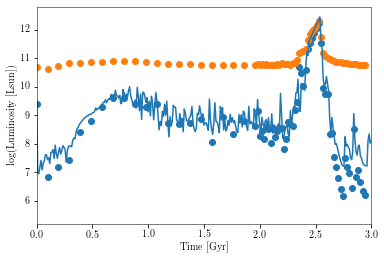

In [5]:
plt.plot(M3M3['TIME'], np.log10(Lagn), label='G3')
plt.scatter(np.mean(simulation_data['time'], axis=0).T[13],
            np.log10(np.mean(simulation_data['l_agn'], axis=0).T[13]), label='G3')
plt.scatter(np.mean(simulation_data['time'], axis=0).T[13],
            np.log10(np.mean(simulation_data['l_bol'], axis=0).T[13]), label='G3')
plt.xlim(0, 3)
plt.xlabel('Time [Gyr]')
plt.ylabel('log(Luminosity [Lsun])')

We estimate the respective $f_{\rm{AGN}}$ (AGN fraction) from the discrete values.

In [6]:
lum_agn = np.mean(simulation_data['l_agn'], axis=0).T[13]
lum_bol = np.mean(simulation_data['l_bol'], axis=0).T[13]
fagn_discrete = lum_agn/lum_bol
time_sim = np.mean(simulation_data['time'], axis=0).T[13]

Text(0, 0.5, 'AGN fraction')

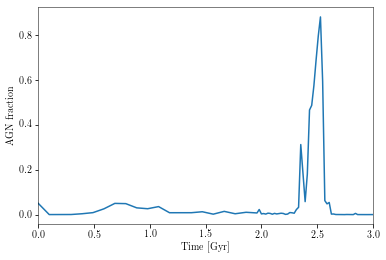

In [7]:
# We clean the arrays to use only the selected snapshots
selected_snap = ~np.logical_and(np.isnan(lum_agn), time_sim == 0.0)
# Then, we plot the fagn
plt.plot(time_sim[selected_snap], fagn_discrete[selected_snap])
plt.xlim(0, 3)
plt.xlabel('Time [Gyr]')
plt.ylabel('AGN fraction')

We print the local minimum an local maximum of the separation between the BH of the galaxies in the M3M3 simulation, and the place in the array where the AGN peaks.

In [8]:
print('Local maximum', argrelextrema(M3M3['D_BH'], np.greater))
print('Local minimum', argrelextrema(M3M3['D_BH'], np.less))
print('AGN peaks', np.nanargmax(fagn_discrete[selected_snap]))

Local maximum (array([148, 232, 246]),)
Local minimum (array([ 89, 223, 245]),)
AGN peaks 49


We plot those locations together with the distance to the BH to verify is correct.

Text(0, 0.5, 'Distance between BHs [Mpc]')

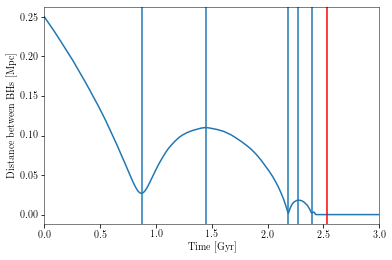

In [9]:
plt.plot(M3M3['TIME'], (M3M3['D_BH']*u.kpc).to(u.Mpc))
plt.axvline(x=M3M3['TIME'][89])
plt.axvline(x=M3M3['TIME'][223])
plt.axvline(x=M3M3['TIME'][148])
plt.axvline(x=M3M3['TIME'][232])
plt.axvline(x=M3M3['TIME'][245])
plt.axvline(x=time_sim[selected_snap][49], c='red')
plt.xlim(0,3)
plt.xlabel('Time [Gyr]')
plt.ylabel('Distance between BHs [Mpc]')

## Read CIGALE data
We read the CIGALE data from Dietricht+18 and the one that we processed for the comparison.

In [10]:
dist_factor = (((Planck13.luminosity_distance(0.0065)).to(u.pc).value/10)**2)  # As assumed in Dietricht+18
data_dietrich = np.full((4, 7, 54), np.nan)
for i in range(7):
    CIGALE_out = Table.read('../Data/SUNRISE/M3M3_'+str(i) +
                            '_all_results.txt', format='ascii')
    data_dietrich[0, i] = CIGALE_out['bayes.agn.fracAGN'][:54]
    data_dietrich[1, i] = CIGALE_out['bayes.agn.fracAGN_err'][:54]
    data_dietrich[2, i] = CIGALE_out['bayes.sfh.sfr'][:54] * dist_factor
    data_dietrich[3, i] = CIGALE_out['bayes.sfh.sfr_err'][:54] * dist_factor

In [11]:
# The redshift was rounded to 0.01 in CIGALE
dist_factor = (
    ((Planck13.luminosity_distance(0.01)).to(u.pc).value/10)**2)
data_andres = np.full((4, 7, 54), np.nan)
for i in range(7):
    CIGALE_out = Table.read(
        '../Data/SUNRISE/results_AndresRepro_'+str(i)+'.fits', format='fits')
    data_andres[0, i] = CIGALE_out['bayes.agn.fracAGN'][:54]
    data_andres[1, i] = CIGALE_out['bayes.agn.fracAGN_err'][:54]
    data_andres[2, i] = CIGALE_out['bayes.sfh.sfr'][:54] * dist_factor
    data_andres[3, i] = CIGALE_out['bayes.sfh.sfr_err'][:54] * dist_factor

The time spans on the simulations are the same as in the processed results from CIGALE.

##### Figure

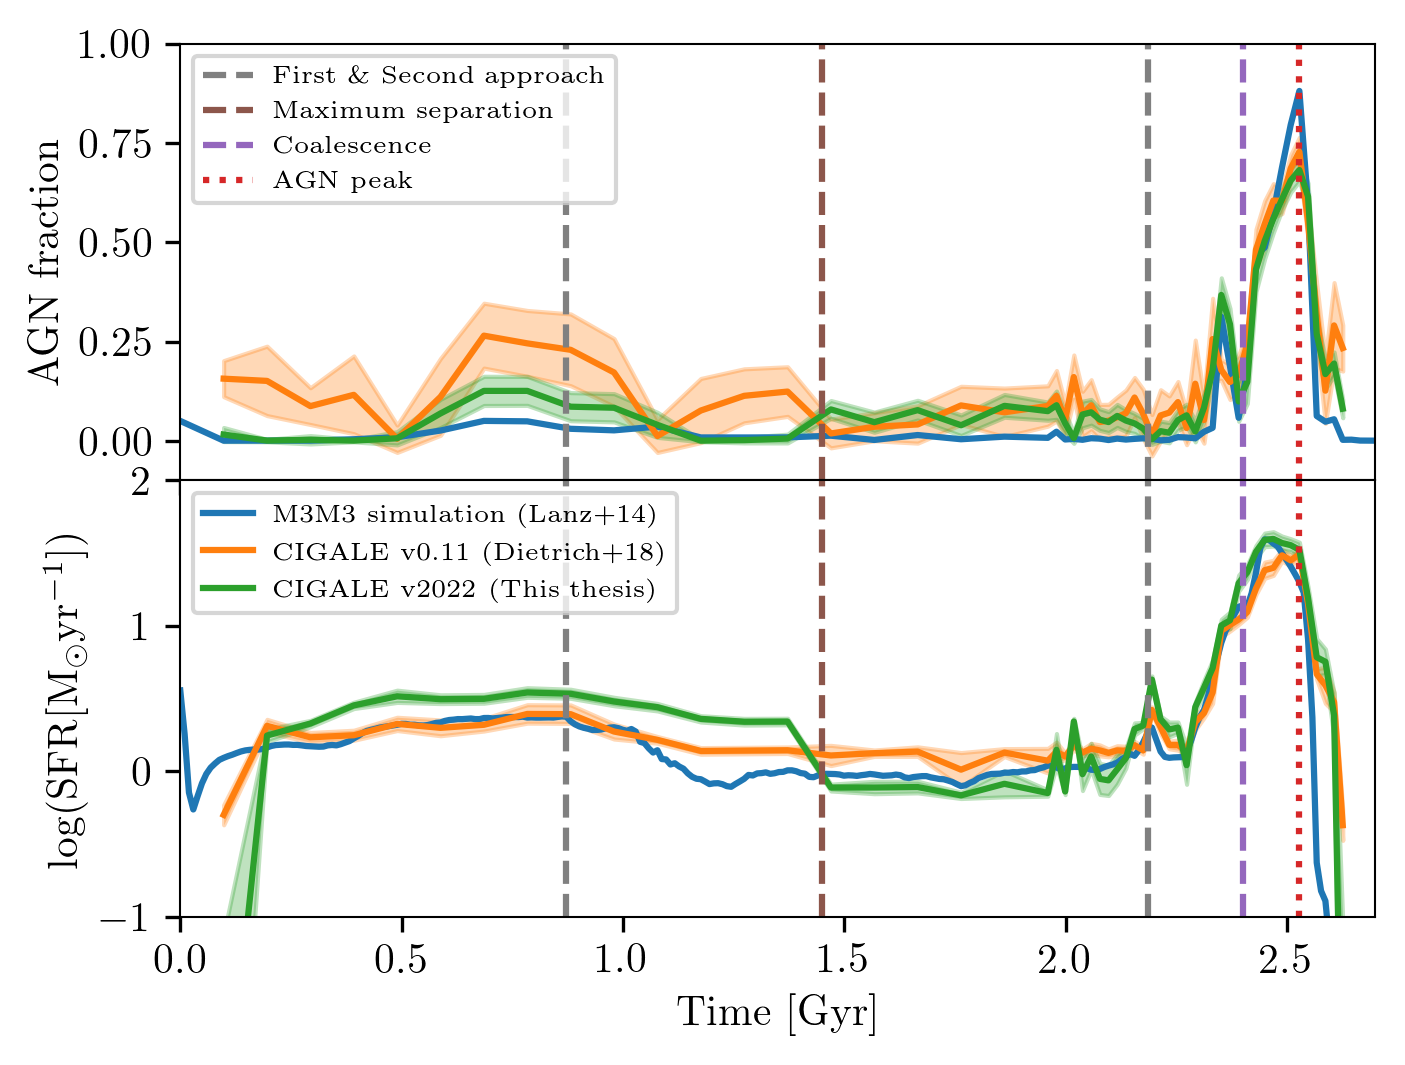

In [12]:
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

fig.set_dpi(DPI)
fig.set_size_inches(WINCHES, HINCHES)

ax1.plot(time_sim[selected_snap], fagn_discrete[selected_snap])
ax1.plot(time_sim[selected_snap][1:55], np.mean(data_dietrich[0], axis=0))
ax1.fill_between(time_sim[selected_snap][1:55],
                 y1=np.mean(data_dietrich[0], axis=0) +
                 np.mean(data_dietrich[1], axis=0),
                 y2=np.mean(data_dietrich[0], axis=0) -
                 np.mean(data_dietrich[1], axis=0),
                 color='C1', alpha=0.3)
ax1.plot(time_sim[selected_snap][1:55], np.mean(data_andres[0], axis=0))
ax1.fill_between(time_sim[selected_snap][1:55],
                 y1=np.mean(data_andres[0], axis=0) +
                 np.mean(data_andres[1], axis=0),
                 y2=np.mean(data_andres[0], axis=0) -
                 np.mean(data_andres[1], axis=0),
                 color='C2', alpha=0.3)
ax1.set_ylabel('AGN fraction')
ax1.set_ylim(-0.1, 1)

ax2.plot(M3M3['TIME'], np.log10(M3M3['SFR']),
         label='M3M3 simulation (Lanz+14)')
d_sfr = np.log10(np.mean(data_dietrich[2], axis=0))
ax2.plot(time_sim[selected_snap][1:55], d_sfr,
         label='CIGALE v0.11 (Dietrich+18)')
ax2.fill_between(time_sim[selected_snap][1:55],
                 y1=d_sfr +
                 (np.mean(data_dietrich[3], axis=0) /
                  (np.mean(data_dietrich[2], axis=0) * np.log(10))),
                 y2=d_sfr -
                 (np.mean(data_dietrich[3], axis=0) /
                  (np.mean(data_dietrich[2], axis=0) * np.log(10))),
                 color='C1', alpha=0.3)

a_sfr = np.log10(np.mean(data_andres[2], axis=0))
ax2.plot(time_sim[selected_snap][1:55], a_sfr,
         label='CIGALE v2022 (This thesis)')
ax2.fill_between(time_sim[selected_snap][1:55],
                 y1=a_sfr +
                 (np.mean(data_andres[3], axis=0) /
                  (np.mean(data_andres[2], axis=0) * np.log(10))),
                 y2=a_sfr -
                 (np.mean(data_andres[3], axis=0) /
                  (np.mean(data_andres[2], axis=0) * np.log(10))),
                 color='C2', alpha=0.3)

ax2.legend(prop={'size': 6})
ax2.set_ylabel(r'$\log(\rm{SFR} [\rm{M}_{\odot} \rm{yr}^{-1}])$')
ax2.set_xlabel('Time [Gyr]')

for axs in [ax1, ax2]:
    axs.axvline(x=M3M3['TIME'][89], ls="--", c='gray',
                label=r'First \& Second approach')
    axs.axvline(x=M3M3['TIME'][148], ls="--",
                c='C5', label='Maximum separation')
    axs.axvline(x=M3M3['TIME'][223], ls="--", c='gray')
    axs.axvline(x=M3M3['TIME'][245], ls="--", c='C4', label='Coalescence')
    axs.axvline(x=time_sim[selected_snap][49],
                ls=":", c='C3', label='AGN peak')

ax2.set_ylim(-1, 2)
ax2.set_xlim(0, 2.7)
plt.subplots_adjust(wspace=0, hspace=0)
ax1.legend(prop={'size': 6})
plt.savefig('../Figures/SFR_AGN_M3M3.pdf', bbox_inches='tight', facecolor='white')

##### Notebook information

In [13]:
%load_ext watermark
%watermark -a "Andres Ramos" -d -v -m
print('Specific Python packages')
%watermark -iv -w -p astroquery

Author: Andres Ramos

Python implementation: CPython
Python version       : 3.8.3
IPython version      : 7.16.1

Compiler    : GCC 7.3.0
OS          : Linux
Release     : 3.10.0-1160.59.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Specific Python packages
astroquery: 0.4.4

json      : 2.0.9
autopep8  : 1.5.7
astropy   : 5.0
matplotlib: 3.4.3
numpy     : 1.22.1

Watermark: 2.2.0

